# Collection & Analysis of Growth Rates at Varying Temperatures

© 2019 Zofii Kaczmarek. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [2]:
import glob
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../../') 
import mwc.io
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

ModuleNotFoundError: No module named 'paramiko'

## Gather Herendeen et al. 1979 Data

To begin, we load data describing growth rates of _E coli._ at temperatures ranging from 13.5˚C to 48˚C, as published in _Herendeen, S. L., VanBogelen, R. A., & Neidhardt, F. C. (1979). Levels of major proteins of Escherichia coli during growth at different temperatures. Journal of bacteriology, 139(1), 185–194._

The data were scraped from Biology By the Numbers Figure 4-8 using GraphClick software. 
BBTM plot here: http://book.bionumbers.org/how-does-temperature-affect-rates-and-affinities/
Data described on BioNumbers here: https://bionumbers.hms.harvard.edu/bionumber.aspx?id=105004
Original paper here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC216844/?page=2

In [2]:
ref_rich = pd.read_csv('../../data/other/temp_growth_rate_comparison/glucose_rich.csv')
ref_minimal = pd.read_csv('../../data/other/temp_growth_rate_comparison/glucose_minimal.csv')

FileNotFoundError: [Errno 2] File b'../../data/other/temp_growth_rate_comparison/glucose_rich.csv' does not exist: b'../../data/other/temp_growth_rate_comparison/glucose_rich.csv'

In [ ]:
ref_rich.columns = ['1000/T','1/t_d','temp_C']
ref_minimal.columns = ['1000/T','1/t_d','temp_C']

ref_rich = ref_rich.sort_values('1000/T')
ref_minimal = ref_minimal.sort_values('1000/T')

## Define Plotting Functions

In [ ]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(1.001*point['x'], 1.001*point['y'], ('%f' % point['val']).rstrip('0').rstrip('.'), fontsize = 8)

def exp_func(x, a, b):
    return a * np.exp(-b * x)

def plot_triptych(df, x1, y1, e1, x2, y2, e2, x3, y3, e3, 
                  ref=True, ref_only=False, annotate=False, ref_lines=True, data_line=True,
                  ref1=ref_rich, ref2=ref_minimal, x_ref='1000/T', y_ref='1/t_d',
                  label1='temp_C', label2='temp_C', label3='temp_C'):
    '''
    Plots three plots describing growth rate vs. temperature:
    time derivative vs temperature
    1/doubling time vs 1000/temperature
    doubling time vs temperature
    
    Arguments
    df: dataframe of the data to be plotted
    x1, y1...: column name (str) for the x and y values for each plot
    e1...: column name (str) for the y error for each plot
    
    ref: boolean that toggles plotting of reference data
    ref_only: boolean that toggles plotting of reference data and omission of experimental data
    
    ref1: dataframe of the rich glucose data
    ref2: dataframe of the minimal glucose data
    x_ref, y_ref: column name (str) for the reference x and y values to be manipulated to create each plot

    '''
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    
    if not ref_only:
        if data_line: 
            fit_dat = df[df[x1] <= 37]
            x_2_filt = 1000/(fit_dat[x2]+273.15)
            y_2_filt = 60/fit_dat[y2] 
            bf_data, _ = scipy.optimize.curve_fit(exp_func,x_2_filt, y_2_filt, p0=(4*10**8,6))
            ax[1].plot(x_2_filt, exp_func(x_2_filt, *bf_data), color = 'mediumpurple')
            
            print('Best fit line for the data is y = {} '
                  '* exp(-{} x), which corresponds to an Arrhenius energy of activation of {}kJ/mol or {}cal/mol.'.format(
                      np.format_float_scientific(bf_data[0], precision = 2),'%.2f'%bf_data[1],
                      '%.2f'%(bf_data[1]*8.31446),'%.2f'%(bf_data[1]*8.31446*0.239)))
            
        x_2 = 1000/(df[x2]+273.15)
        y_2 = 60/df[y2] 
        
        ax[0].errorbar(df[x1], 60*df[y1], yerr = 60*df[e1], fmt='.', ecolor='rebeccapurple', color='darkorchid')
        ax[1].errorbar(x_2, y_2, yerr = 60*df[e2]/df[y2]**2, fmt='.', ecolor='rebeccapurple', color='darkorchid')
        ax[2].errorbar(df[x3], df[y3], yerr = df[e3], fmt='.', ecolor='rebeccapurple', color='darkorchid')

        ax[1].set_yticks(list(np.arange(0.1,1.1,0.1)), True)
        ax[1].set_ylim(0.1, 1.5)
        
        if annotate: label_point(x_2, y_2, df[label2], ax[1])
            
    if ref or ref_only:
        if ref_lines: 
            bf_minimal, _ = scipy.optimize.curve_fit(exp_func,ref2[x_ref], ref2[y_ref], p0=(4*10**8,6))
            bf_rich, _ = scipy.optimize.curve_fit(exp_func, ref1[x_ref][6:-4], ref1[y_ref][6:-4], p0=(8*10**8,6))
            ax[1].plot(ref2[x_ref], exp_func(ref2[x_ref], *bf_minimal), color = 'dodgerblue')
            ax[1].plot(ref1[x_ref][6:-4], exp_func(ref1[x_ref][6:-4], *bf_rich), color = 'orangered')
            print('Best fit line for the minimal glucose reference is y = {} '
                  '* exp(-{} x), which corresponds to an Arrhenius energy of activation of {}kJ/mol or {}cal/mol.'.format(
                      np.format_float_scientific(bf_minimal[0], precision = 2),'%.2f'%bf_minimal[1],
                      '%.2f'%(bf_minimal[1]*8.31446),'%.2f'%(bf_minimal[1]*8.31446*0.239)))
            print('Best fit line for the rich glucose reference is y = {} '
                  '* exp(-{} x), which corresponds to an Arrhenius energy of activation of {}kJ/mol or {}cal/mol.'.format(
                      np.format_float_scientific(bf_rich[0],precision = 2),'%.2f'%bf_rich[1],
                      '%.2f'%(bf_rich[1]*8.31446),'%.2f'%(bf_rich[1]*8.31446*0.239)))

        ax[0].scatter(1000/ref1[x_ref] - 273.15, np.log(2)*ref1[y_ref], marker ='.', color = 'red')
        ax[0].scatter(1000/ref2[x_ref] - 273.15, np.log(2)*ref2[y_ref], marker ='.', color = 'blue')
        ax[1].semilogy(ref1[x_ref], ref1[y_ref], '.', color = 'red')
        ax[1].semilogy(ref2[x_ref], ref2[y_ref], '.', color = 'blue')
        ax[2].scatter(1000/ref1[x_ref] - 273.15, 60/ref1[y_ref], marker ='.', color = 'red')
        ax[2].scatter(1000/ref2[x_ref] - 273.15, 60/ref2[y_ref], marker ='.', color = 'blue')
        ax[1].set_yticks(list(np.arange(0.1,1.1,0.1)+[2.0]), True)
        ax[1].set_ylim(0.1, 2)
        
        if annotate: 
            label_point(ref1[x_ref], ref1[y_ref], ref1[label2], ax[1])
            label_point(ref2[x_ref], ref2[y_ref], ref2[label2], ax[1])

    ax[0].set_title('GP growth rate vs temp', fontsize = 10)
    ax[0].set_xlabel('temperature (C)')
    ax[0].set_ylabel('max time derivative (hour^-1)')
    ax[0].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

    ax[1].set_title('1/t_d vs temp', fontsize = 10)
    ax[1].set_yscale('log')
    ax[1].grid(True, which="both")
    ax[1].set_xticks(np.arange(3.1,3.6,0.1))
    ax[1].set_yticks([], False)
    ax[1].yaxis.set_minor_formatter(FormatStrFormatter('%.1f'))
    ax[1].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax[1].set_xlabel('1000/temperature(K)')
    ax[1].set_ylabel('1/doubling time (hour^-1, log scale)')

    ax[2].set_title('doubling time vs temp', fontsize=10)
    ax[2].set_xlabel('temperature (C)')
    ax[2].set_ylabel('doubling time (min)')
    ax[2].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

    fig.tight_layout()

## Plot Reference Data

In [3]:
plot_triptych(pd.DataFrame(),'','','','','','','','','', ref_only=True, annotate=True)
#plt.savefig('reference.png')

NameError: name 'plot_triptych' is not defined

## Whole-Plate Analyses: `deltaLacI` in Glucose

Now, we consider data from running Gaussian processing on 96-well plates as pooled data. (Each plate was analyzed and generated a single maximum growth rate.)

First we collect and tidy the data. 

In [4]:
# Collect and concat gaussian processing output statistics for accepted experiments
data_dir = '../processing/growth_curves_plate_reader'
growth_exp = glob.glob(f'{data_dir}*growth')
growth_dfs = []
for _, d in enumerate(growth_exp):
    file = glob.glob(f'{d}/output/delta_glucose/gp_output_stats.csv')
    if file != []:
        state = mwc.io.scrape_frontmatter(d)
        if state['status'].lower() == 'accepted':
            growth_df = pd.read_csv(file[0]).drop(columns = 'Unnamed: 0')
            growth_df['date'] = d.split('_')[0]
            growth_df['temp_C'] = d.split('_')[2][0:2]
            growth_dfs.append(growth_df)
growth_df = pd.concat(growth_dfs)
growth_df['carbon'] = 'glucose'
growth_df['operator'] = 'O2'
growth_df.to_csv('temp_analysis/compiled_gp_stats.csv', index=False)

ValueError: No objects to concatenate

In [5]:
# Or, load the previously compiled dataframe of whole-growth-plate growth rates.
growth_df = pd.read_csv('temp_analysis/compiled_gp_stats.csv')

FileNotFoundError: [Errno 2] File b'temp_analysis/compiled_gp_stats.csv' does not exist: b'temp_analysis/compiled_gp_stats.csv'

In [7]:
# Select the first derivative and standard deviation parameters
growth_rate_df = growth_df[
    (growth_df['parameter'] == 'max df') | (growth_df['parameter'] == 'max df std')].copy().reset_index(drop=True)
# Rename
growth_rate_df.loc[growth_rate_df['parameter'] == 'max df','parameter'] = 'growth_rate'
growth_rate_df.loc[growth_rate_df['parameter'] == 'max df std','parameter'] = 'growth_rate_std'

# Reshape
wide = growth_rate_df.pivot(index = 'date', columns='parameter', values='value').reset_index()
long = growth_rate_df[['date','temp_C','carbon','operator']].drop_duplicates()
stats_df = pd.merge(long,wide, how='left', on='date').sort_values('date')

# Calculate doubling times and standard deviations from first derivative
stats_df['doub_time_minutes'] = np.log(2)/stats_df['growth_rate']
stats_df['doub_time_std'] = np.log(2)*stats_df['growth_rate_std']/(stats_df['growth_rate'])**2

# Convert temperatures from strings to ints
stats_df['temp_C'] = stats_df['temp_C'].astype('int')

stats_df = stats_df.sort_values('temp_C')

Next, we plot the results using different measures of error.

### Whole-Plate Growth Rates and Model Fit Errors

We begin by plotting the data so that the replicates at each temperature can be seen.

No averaging or error propogation. Errors from model fits only.

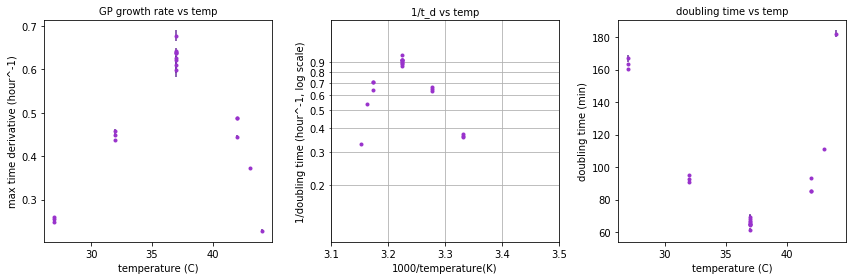

In [8]:
plot_triptych(stats_df, 
              'temp_C','growth_rate','growth_rate_std', 
              'temp_C','doub_time_minutes','doub_time_std',
              'temp_C','doub_time_minutes','doub_time_std',
              ref = False, data_line=False)
#plt.savefig('temp_analysis/delta_glucose_growth_rate_vs_temperature_errors_from_fit.png')

### Brief Discussion of the Error

https://www.researchgate.net/post/Propagating_uncertainties_when_calculating_the_mean

> If you have quite similar observed errors, you may assume that the underlying random variables do have the same variance. 

> Now, let write the model. Your observation Xi is the sum of a « true » value, x, and the two errors you mention, E1 with V(E1) = 0.02² mW² and E2 with V(E2) = (0.05 x)² (or (0.05 [x + E1])² ? clarify... and adapt ; I continue on the first one).
Then V(Xi) = V(E1) + V(E2) = 0.02² + 0.05² x², assuming E1 and E2 are independant.
Since this variance is constant (as far as the "true" value x does not change between measurements), then it will be correctly estimated by the usual variance estimator, so no need for extra correction...

For now, I assume the variance generated by the fits are independent of temperature and plate well, and thus constant between measurments. Then, the fit variances need not be included when calculating the error of the means at each temperature. 

In reality, the temperature is not constant across the plate, so the true value of growth rate does depend on position (well). These data have already pooled wells for each plate, and since the non-uniformity of temperature is more of an issue at extreme temperatures (here, the high temperatures), where growth rate is highly sensitive to temperature, we simply expect more uncertain fits (growth rates) at extreme temperatures. This does not seem to be reflected in the plot above, suggesting the variance may be more constant than this reasoning would suggest.

In fact, a plot of the standard deviations generated by the GP model fits (below) shows relatively constant error across temperatures, with the exception of four experiments at 37˚C.

Text(0,0.5,'standard deviation (hour^-1)')

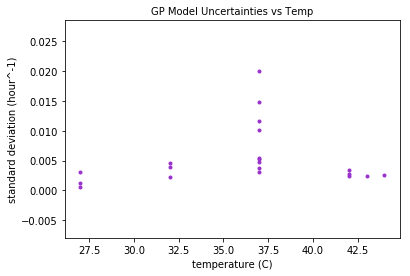

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(stats_df['temp_C'], 60*stats_df['growth_rate_std'], marker = '.', color='darkorchid')
ax.set_title('GP Model Uncertainties vs Temp', fontsize = 10)
ax.set_xlabel('temperature (C)')
ax.set_ylabel('standard deviation (hour^-1)')

### Whole Plate Mean Growth Rates and SEM
Averaged data, with standard error of the mean.

In [10]:
stats_df_avgd = stats_df.drop(columns = ['growth_rate_std', 'doub_time_std']).groupby(
    ['temp_C','carbon','operator']).agg(['mean','sem','std'])
stats_df_avgd.columns = ['_'.join(col) for col in stats_df_avgd.columns.values]
stats_df_avgd = stats_df_avgd.reset_index()

Best fit line for the data is y = 1.08e+11 * exp(-7.90 x), which corresponds to an Arrhenius energy of activation of 65.71kJ/mol or 15.70cal/mol.
Best fit line for the minimal glucose reference is y = 8.58e+08 * exp(-6.37 x), which corresponds to an Arrhenius energy of activation of 52.99kJ/mol or 12.67cal/mol.
Best fit line for the rich glucose reference is y = 4.56e+09 * exp(-6.72 x), which corresponds to an Arrhenius energy of activation of 55.91kJ/mol or 13.36cal/mol.


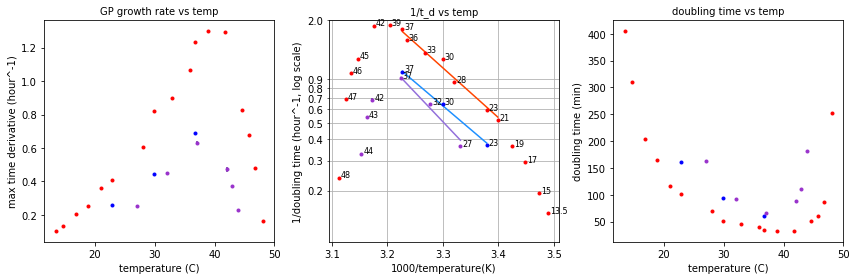

In [11]:
plot_triptych(stats_df_avgd, 
              'temp_C','growth_rate_mean','growth_rate_sem', 
              'temp_C','doub_time_minutes_mean','doub_time_minutes_sem',
              'temp_C','doub_time_minutes_mean','doub_time_minutes_sem',
              ref = True, annotate = True)
#plt.savefig('temp_analysis/delta_glucose_growth_rate_vs_temperature_errors_of_mean.png')

### Whole Plate Mean Growth Rates and Standard Deviation
Averaged data, with standard deviation of the replicates.

Best fit line for the data is y = 1.08e+11 * exp(-7.90 x), which corresponds to an Arrhenius energy of activation of 65.71kJ/mol or 15.70cal/mol.
Best fit line for the minimal glucose reference is y = 8.58e+08 * exp(-6.37 x), which corresponds to an Arrhenius energy of activation of 52.99kJ/mol or 12.67cal/mol.
Best fit line for the rich glucose reference is y = 4.56e+09 * exp(-6.72 x), which corresponds to an Arrhenius energy of activation of 55.91kJ/mol or 13.36cal/mol.


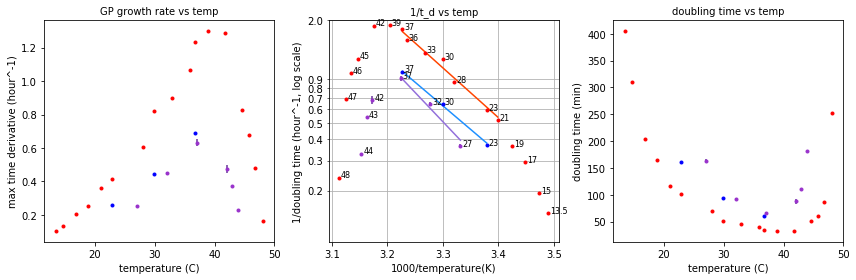

In [12]:
plot_triptych(stats_df_avgd, 
              'temp_C','growth_rate_mean','growth_rate_std', 
              'temp_C','doub_time_minutes_mean','doub_time_minutes_std',
              'temp_C','doub_time_minutes_mean','doub_time_minutes_std',
              ref = True, annotate = True)
#plt.savefig('temp_analysis/delta_glucose_growth_rate_vs_temperature_std_of_replicates.png')

## Per-Well Analyses: `deltaLacI` in Glucose

Next, we consider data from running Gaussian processing each well separately.

First we collect and tidy the data. 

In [13]:
# Collect and concat gaussian processing output statistics for accepted experiments
data_dir = '../processing/growth_curves_plate_reader'
growth_exp = glob.glob(f'{data_dir}*growth')
growth_dfs = []
for _, d in enumerate(growth_exp):
    if glob.glob(f'{d}/output/delta_glucose/per_well_stats.csv') != []:
        state = mwc.io.scrape_frontmatter(d)
        if state['status'].lower() == 'accepted':
            growth_df = pd.read_csv(glob.glob(f'{d}/output/delta_glucose/per_well_stats.csv')[0]).drop(columns = 'strain')
            growth_df['date'] = d.split('_')[0]
            growth_df['temp_C'] = d.split('_')[2][0:2]
            growth_dfs.append(growth_df)
growth_df_pw = pd.concat(growth_dfs)
growth_df_pw['carbon'] = 'glucose'
growth_df_pw['operator'] = 'O2'
growth_df_pw.to_csv('temp_analysis/compiled_per_well_stats.csv', index=False)

In [14]:
# Or, load the previously compiled dataframe of per-well growth rates.
growth_df_pw = pd.read_csv('temp_analysis/compiled_per_well_stats.csv')

In [15]:
# Select the first derivative and standard deviation parameters
growth_rate_df_pw = growth_df_pw[
    (growth_df_pw['parameter'] == 'max df') | (growth_df_pw['parameter'] == 'max df std')].copy().reset_index(drop=True)

# Rename
growth_rate_df_pw.loc[growth_rate_df_pw['parameter'] == 'max df','parameter'] = 'growth_rate'
growth_rate_df_pw.loc[growth_rate_df_pw['parameter'] == 'max df std','parameter'] = 'growth_rate_std'

# Add unique tag to allow pivoting
named = growth_rate_df_pw.copy()
named['date'] = named['date'].astype('str')
named['well_id'] = named['well_id'].astype('str')
named['unique_id'] = named['date']+named['well_id']
# Reshape
wide = named.pivot(index = 'unique_id', columns='parameter', values='value').reset_index()
long = named[['unique_id','temp_C','carbon','operator']].drop_duplicates()
stats_df_pw = pd.merge(long,wide, how='left', on='unique_id').sort_values('unique_id')
# Recover date and well id from unique id
stats_df_pw['date'] = stats_df_pw['unique_id'].str[:-2]
stats_df_pw['well_id'] = stats_df_pw['unique_id'].str[8:]
#stats_df_pw = stats_df_pw.drop(columns = ['unique_id'])

# Calculate doubling times and standard deviations from first derivative
stats_df_pw['doub_time_minutes'] = np.log(2)/stats_df_pw['growth_rate']
stats_df_pw['doub_time_std'] = np.log(2)*stats_df_pw['growth_rate_std']/(stats_df_pw['growth_rate'])**2

# Convert temperatures from strings to ints
stats_df_pw['temp_C'] = stats_df_pw['temp_C'].astype('int')

stats_df_pw = stats_df_pw.sort_values('temp_C')

### Removal of Pathological Fits

Some wells were fit to pathological derivative curves, with large error regions on the fits. This sometimes led to extremely high growth rates, such as 20190317 well 27 with a growth rate of 20 min^-1 and 20190304 well 56 with a growth rate of 5.7 min^-1. Others were within a reasonable physical range of growth rates, but not reflections of a meaningful derivative of the data, so they also ought to be excluded. 

* 20190213 C4 (28)
* 20190304 E8 (56)
* 20190307 C7 (31)
* 20190316 F4 (64)
* 20190317 C3 (27)

In [16]:
stats_df_pw[stats_df_pw['unique_id'].isin(['2019021328','2019030456','2019030731','2019031664','2019031727'])]

,unique_id,temp_C,carbon,operator,growth_rate,growth_rate_std,date,well_id,doub_time_minutes,doub_time_std
236,2019030456,27,glucose,O2,5.703713,1.050041,20190304,56,0.121526,0.022373
176,2019031664,37,glucose,O2,0.004606,0.000910,20190316,64,150.498532,29.742798
37,2019021328,42,glucose,O2,0.000273,0.000077,20190213,28,2537.994381,718.472753
388,2019030731,42,glucose,O2,0.013222,0.001024,20190307,31,52.425208,4.060637
352,2019031727,43,glucose,O2,19.997700,3.705797,20190317,27,0.034661,0.006423


In [17]:
stats_df_pw_filt = stats_df_pw[~stats_df_pw['unique_id'].isin(
    ['2019021328','2019030456','2019030731','2019031664','2019031727'])]

### Per-Well Growth Rates and Model Fit Errors
No averaging or error propogation. Errors from model fits only.

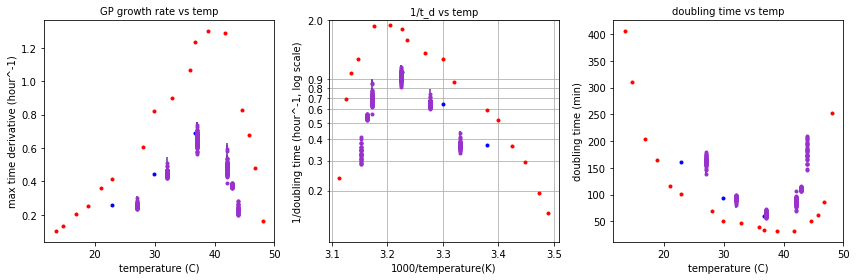

In [20]:
plot_triptych(stats_df_pw_filt, 
              'temp_C','growth_rate','growth_rate_std', 
              'temp_C','doub_time_minutes','doub_time_std',
              'temp_C','doub_time_minutes','doub_time_std',
             data_line = False, ref_lines = False)
#plt.savefig('temp_analysis/delta_glucose_growth_rate_vs_temperature_pw_errors_from_fit.png')

### Per-Well Mean Growth Rates and SEM
Averaged data, plotted with standard error of the mean.

In [21]:
stats_df_pw_avgd = stats_df_pw_filt.drop(columns = ['growth_rate_std', 'doub_time_std']).groupby(
    ['temp_C','carbon','operator']).agg(['mean','sem','std'])
stats_df_pw_avgd.columns = ['_'.join(col) for col in stats_df_pw_avgd.columns.values]
stats_df_pw_avgd = stats_df_pw_avgd.reset_index()

Best fit line for the data is y = 1.82e+11 * exp(-8.06 x), which corresponds to an Arrhenius energy of activation of 67.01kJ/mol or 16.02cal/mol.
Best fit line for the minimal glucose reference is y = 8.58e+08 * exp(-6.37 x), which corresponds to an Arrhenius energy of activation of 52.99kJ/mol or 12.67cal/mol.
Best fit line for the rich glucose reference is y = 4.56e+09 * exp(-6.72 x), which corresponds to an Arrhenius energy of activation of 55.91kJ/mol or 13.36cal/mol.


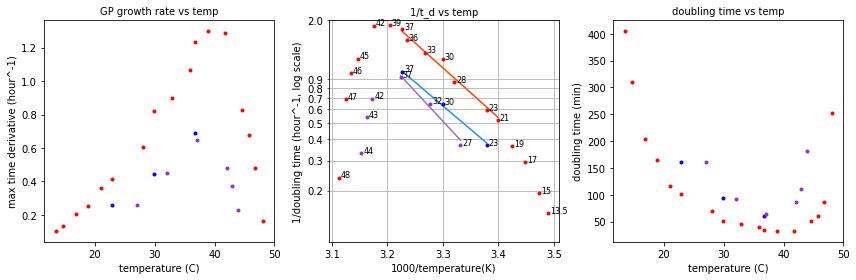

In [22]:
plot_triptych(stats_df_pw_avgd, 
              'temp_C','growth_rate_mean','growth_rate_sem', 
              'temp_C','doub_time_minutes_mean','doub_time_minutes_sem',
              'temp_C','doub_time_minutes_mean','doub_time_minutes_sem',
              ref = True, annotate=True)
#plt.savefig('temp_analysis/delta_glucose_growth_rate_vs_temperature_pw_errors_of_mean.png')

### Per-Well Mean Growth Rates and Standard Deviation
Averaged data, plotted with standard devation of replicates.

Best fit line for the data is y = 1.82e+11 * exp(-8.06 x), which corresponds to an Arrhenius energy of activation of 67.01kJ/mol or 16.02cal/mol.
Best fit line for the minimal glucose reference is y = 8.58e+08 * exp(-6.37 x), which corresponds to an Arrhenius energy of activation of 52.99kJ/mol or 12.67cal/mol.
Best fit line for the rich glucose reference is y = 4.56e+09 * exp(-6.72 x), which corresponds to an Arrhenius energy of activation of 55.91kJ/mol or 13.36cal/mol.


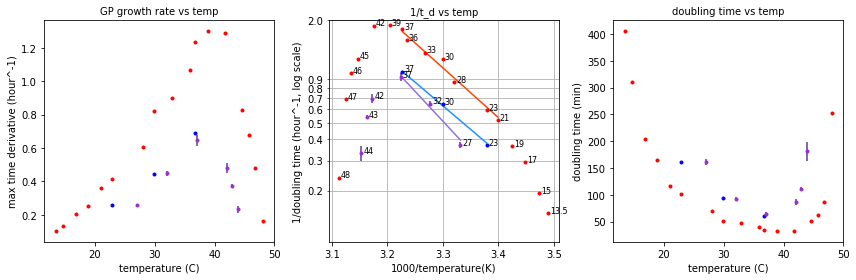

In [23]:
plot_triptych(stats_df_pw_avgd, 
              'temp_C','growth_rate_mean','growth_rate_std', 
              'temp_C','doub_time_minutes_mean','doub_time_minutes_std',
              'temp_C','doub_time_minutes_mean','doub_time_minutes_std',
              ref = True, annotate=True)
#plt.savefig('temp_analysis/delta_glucose_growth_rate_vs_temperature_pw_std_of_replicates.png')

And finally, let's look at the numbers for growth rates at each temperature.

In [24]:
stats_df_pw_avgd

,temp_C,carbon,operator,growth_rate_mean,growth_rate_sem,growth_rate_std,doub_time_minutes_mean,doub_time_minutes_sem,doub_time_minutes_std
0,27,glucose,O2,0.004289,0.000016,0.000156,161.814494,0.588831,5.739211
1,32,glucose,O2,0.007499,0.000025,0.000248,92.525029,0.305314,2.991449
2,37,glucose,O2,0.010779,0.000053,0.000541,64.466676,0.314900,3.226770
3,42,glucose,O2,0.008045,0.000051,0.000499,86.482391,0.548305,5.316012
4,43,glucose,O2,0.006247,0.000027,0.000149,111.012744,0.473512,2.636403
5,44,glucose,O2,0.003871,0.000068,0.000383,180.703290,3.065096,17.338801
